#First, we will upload and process the data

In [ ]:
#upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mariasultanbekova","key":"31d0644392b95db69ce4160b7908ac50"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d yaswanthgali/dog-images

 97% 731M/750M [00:04<00:00, 177MB/s]
100% 750M/750M [00:04<00:00, 179MB/s]


In [ ]:
!unzip /content/dog-images.zip

In [ ]:
import numpy as np 
from PIL import Image
import pickle
import torch
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import cv2
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

from torchvision import transforms, models
import seaborn as sns
sns.set_style('darkgrid')


import os

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

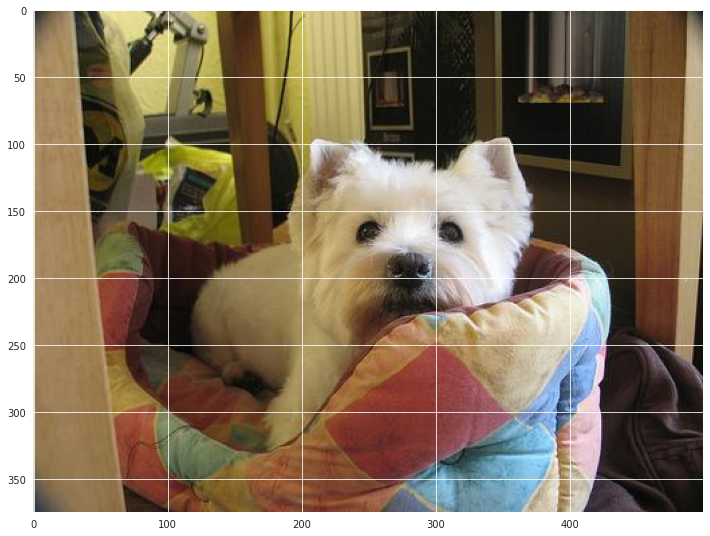

In [ ]:
import matplotlib.pyplot as plt

img = cv2.imread('/content/images/images/n02098286-West_Highland_white_terrier/n02098286_1036.jpg')
img = cv2.cvtColor(img,  cv2.COLOR_RGB2BGR)

plt.figure(figsize=(12,12))
plt.imshow(img)

In [ ]:
class_names = []
len_of_class = []
data_root = '/content/images/images/'


for breed in os.listdir(data_root):
    class_names.append(breed)
    len_of_class.append(len(os.listdir(os.path.join(data_root, breed))))

print(class_names)
print(len_of_class)
print(len(class_names))

['n02085782-Japanese_spaniel', 'n02099849-Chesapeake_Bay_retriever', 'n02096585-Boston_bull', 'n02112350-keeshond', 'n02091831-Saluki', 'n02113712-miniature_poodle', 'n02106382-Bouvier_des_Flandres', 'n02100583-vizsla', 'n02113978-Mexican_hairless', 'n02112137-chow', 'n02086646-Blenheim_spaniel', 'n02104029-kuvasz', 'n02088632-bluetick', 'n02093428-American_Staffordshire_terrier', 'n02091467-Norwegian_elkhound', 'n02097047-miniature_schnauzer', 'n02108422-bull_mastiff', 'n02094114-Norfolk_terrier', 'n02115641-dingo', 'n02113624-toy_poodle', 'n02086910-papillon', 'n02105056-groenendael', 'n02094433-Yorkshire_terrier', 'n02105855-Shetland_sheepdog', 'n02096437-Dandie_Dinmont', 'n02101388-Brittany_spaniel', 'n02110958-pug', 'n02097298-Scotch_terrier', 'n02091134-whippet', 'n02099429-curly-coated_retriever', 'n02090622-borzoi', 'n02109047-Great_Dane', 'n02106550-Rottweiler', 'n02096051-Airedale', 'n02116738-African_hunting_dog', 'n02100877-Irish_setter', 'n02101006-Gordon_setter', 'n020953

In [ ]:
import shutil 
from tqdm import tqdm

train_dir = '/content/train/'
val_dir = '/content/validation/'

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name[10:]), exist_ok=True)


for class_name in class_names:
    source_dir = os.path.join(data_root, class_name) 
    for file_name in tqdm(os.listdir(source_dir)): 
        dest_dir = os.path.join(train_dir, class_name[10:]) 
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))


In [ ]:
TRAIN_DIR = Path('/content/train')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                      stratify=train_val_labels)

#Let's create our own dataset for convenience (in the future it will help us to make a beautiful visualization)

In [ ]:
class DogsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [ ]:
batch_size = 8


train_dataset = DogsDataset(train_files, mode='train')
val_dataset = DogsDataset(val_files, mode='val')


train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
datasetsizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [ ]:
len(train_dataset), len(train_dataloader)

(15435, 1930)

In [ ]:
len(train_dataset)/8

1929.375

#Let's take a look at these cute puppies

In [ ]:
def show_image_classification(dataloader, title=''):
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    X_batch, y_batch = next(iter(dataloader))

    fig, ax = plt.subplots(2, 3, figsize=(12, 9))

    for x_item, y_item, i, j in zip(X_batch, y_batch, [0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]):
    
        image = x_item.permute(1, 2, 0).numpy()
        image = std * image + mean
        
        title = class_names[y_item][10:]
        
        ax[i, j].imshow(image.clip(0, 1))
        ax[i, j].set_title(title)

        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

    fig.tight_layout()
    plt.show()

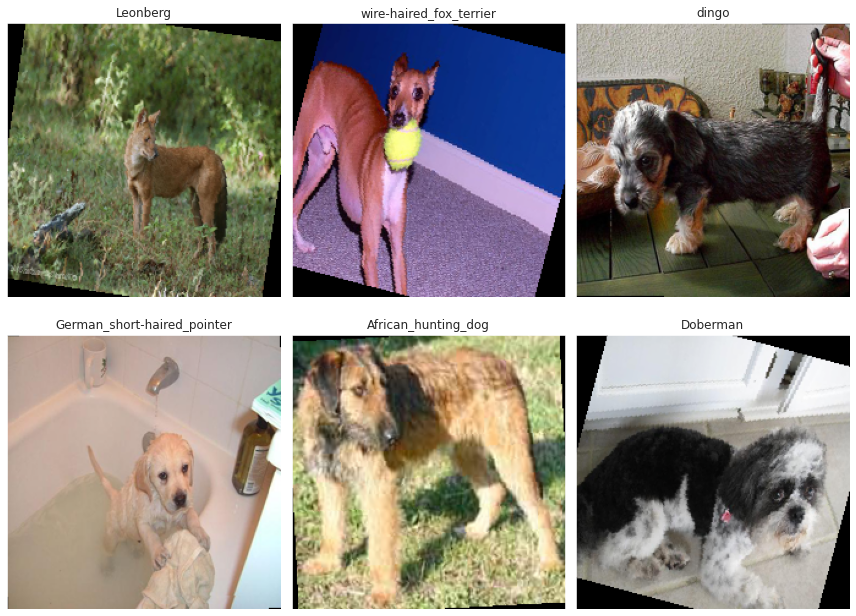

In [ ]:
show_image_classification(train_dataloader)

#Model training

In [ ]:
from tqdm.autonotebook import tqdm, trange
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
  
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True) #here we tell the model to accumulate statistics for BatchNorm layers
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                inputs, labels = data

                if torch.cuda.is_available:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                if phase=="train":
                    optimizer.zero_grad()

                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / datasetsizes[phase]
            epoch_acc = running_corrects / datasetsizes[phase]
            
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    torch.save(best_model_wts, 'weights_for_classification.h5')


In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 120)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.01)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=30);

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

train iter::   0%|          | 0/1930 [00:00<?, ?it/s]

val iter::   0%|          | 0/644 [00:00<?, ?it/s]

Training complete in 91m 16s
Best val Acc: 0.806803


In [ ]:
files.download('/content/weights_for_classification.h5')
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>